In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import pickle
import warnings
from sklearn.exceptions import ConvergenceWarning
import shap
import numpy as np
import seaborn as sns

In [2]:
df_dict = {
    'all': {},
    'CDS': {},
    'CAT': {}
}
df_dict['all']['X_train'] = pd.read_csv('train/X_train.csv')
df_dict['all']['y_train'] = pd.read_csv('train/y_train.csv')
df_dict['all']['X_test'] = pd.read_csv('test/X_test.csv')
df_dict['all']['y_test'] = pd.read_csv('test/y_test.csv')
df_dict['CDS']['X_train'] = df_dict['all']['X_train'].iloc[:,18:]
df_dict['CDS']['y_train'] = df_dict['all']['y_train']
df_dict['CDS']['X_test'] = df_dict['all']['X_test'].iloc[:,18:]
df_dict['CDS']['y_test'] = df_dict['all']['y_test']
df_dict['CAT']['X_train'] = pd.read_csv('train/X_train_cat.csv').iloc[:,18:]
df_dict['CAT']['y_train'] = pd.read_csv('train/y_train_cat.csv')
df_dict['CAT']['X_test'] = pd.read_csv('test/X_test_cat.csv').iloc[:,18:]
df_dict['CAT']['y_test'] = pd.read_csv('test/y_test_cat.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train/X_train.csv'

In [ ]:
class LRResults:
    def __init__(self, clf, y_pred, f1, acc_anxiety, acc_depression, model_name, rows, X_test, y_test, best_hp, param_grid, col_names):
        self.clf = clf
        self.y_pred = y_pred
        self.f1 = f1
        self.acc_anxiety = acc_anxiety
        self.acc_depression = acc_depression
        self.name = model_name
        self.rows = rows
        self.X_test = X_test
        self.y_test = y_test
        self.best_hp = best_hp
        self.param_grid = param_grid
        self.col_names = col_names
        
        
    param_grid = [
    {'estimator__penalty': ['l1'], 'estimator__solver': [ 'saga']},
    {'estimator__penalty': ['l2'], 'estimator__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
    {'estimator__penalty': ['elasticnet'], 'estimator__solver': ['saga']}
    ]
      
    def build_model(X_train, y_train, X_test, y_test, param_grid, model_name):
        col_names = X_train.columns
        scaler = StandardScaler()
        normalizer = Normalizer()

        pipeline = Pipeline([
            ('scaler', scaler),
            ('normalizer', normalizer)
        ])
        
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        lr = LogisticRegression(max_iter=2500)
        multi_lr = MultiOutputClassifier(lr)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            clf = GridSearchCV(multi_lr, param_grid, cv=5, verbose=0, n_jobs=-1, scoring='f1_macro')
        #Train the model using the training sets
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        pickle.dump(clf, open(f'models/{model_name}.pkl', 'wb'))
        pickle.dump(scaler, open(f'models/scaler.pkl', 'wb'))

        f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
        acc_anxiety = round(accuracy_score(y_test.iloc[:,0], y_pred[:,0]), 3)
        acc_depression = round(accuracy_score(y_test.iloc[:,1], y_pred[:,1]), 3)
        # cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro') 
        return LRResults(clf, y_pred, f1, acc_anxiety, acc_depression, 
                            model_name, X_test.shape[0], X_test, y_test, 
                            clf.best_params_, param_grid, col_names)
        
    def plot_training_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_test, self.y_test, cv=5, n_jobs=-1)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.figure()
        plt.title(f"Learning Curve for {self.name}")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - np.std(train_scores, axis=1),
                         train_scores_mean + np.std(train_scores, axis=1), alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - np.std(test_scores, axis=1),
                         test_scores_mean + np.std(test_scores, axis=1), alpha=0.1,
                         color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()

In [4]:
# Store results
all_results = {}

for subset_name, data in df_dict.items():
    print(f"Training model for subset: {subset_name}")
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    lr_result = LRResults.build_model(X_train, y_train, X_test, y_test, LRResults.param_grid, model_name=f'{subset_name}_lr')

    # Store results by subset name
    all_results[subset_name] = lr_result

for subset, result in all_results.items():
    print(f"Results for {subset}: F1 = {result.f1}, Anxiety Acc = {result.acc_anxiety}, Depression Acc = {result.acc_depression}")

Training model for subset: all


/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 450, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel

Training model for subset: CDS


/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 450, in f

Training model for subset: CAT
Results for all: F1 = 0.675, Anxiety Acc = 0.591, Depression Acc = 0.569
Results for CDS: F1 = 0.683, Anxiety Acc = 0.558, Depression Acc = 0.586
Results for CAT: F1 = 0.753, Anxiety Acc = 0.603, Depression Acc = 0.614


/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 450, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel

In [5]:
for subset, result in all_results.items():
    print(f"Results for {subset}:")
    print(classification_report(result.y_test, result.y_pred, zero_division=0, target_names=y_train.columns.values))
    test_accuracy = accuracy_score(result.y_test, result.y_pred)
    print(f"Test Set Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy anxiety: {result.acc_anxiety:.4f}")
    print(f"Accuracy depression: {result.acc_depression:.4f}")
    print(result.name)
    print('\n')

Results for all:
                  precision    recall  f1-score   support

   group_anxiety       0.65      0.68      0.67       278
group_depression       0.63      0.75      0.68       290

       micro avg       0.64      0.71      0.68       568
       macro avg       0.64      0.71      0.68       568
    weighted avg       0.64      0.71      0.68       568
     samples avg       0.60      0.70      0.62       568

Test Set Accuracy: 0.3750
Accuracy anxiety: 0.5910
Accuracy depression: 0.5690
all_lr


Results for CDS:
                  precision    recall  f1-score   support

   group_anxiety       0.62      0.70      0.66       278
group_depression       0.63      0.81      0.71       290

       micro avg       0.62      0.76      0.68       568
       macro avg       0.62      0.76      0.68       568
    weighted avg       0.62      0.76      0.68       568
     samples avg       0.62      0.76      0.65       568

Test Set Accuracy: 0.3254
Accuracy anxiety: 0.5580
Accuracy 

In [6]:
# Plot confusion matrices for all subsets and both labels
def plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression']):
    num_subsets = len(all_results)
    fig, axes = plt.subplots(num_subsets, 2, figsize=(10, 4 * num_subsets))
    
    if num_subsets == 1:
        axes = [axes]  # Ensure iterable shape consistency if only 1 subset
    
    for row_idx, (subset, result) in enumerate(all_results.items()):
        
        for col_idx, label in enumerate(label_names):
            ax = axes[row_idx][col_idx] if num_subsets > 1 else axes[0][col_idx]

            # Confusion Matrix
            cm = confusion_matrix(result.y_test.iloc[:, col_idx], result.y_pred[:, col_idx])
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                        xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
            
            accuracy = np.trace(cm) / np.sum(cm)
            ax.set_title(f"{subset} - {label}: Acc = {accuracy:.2f}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

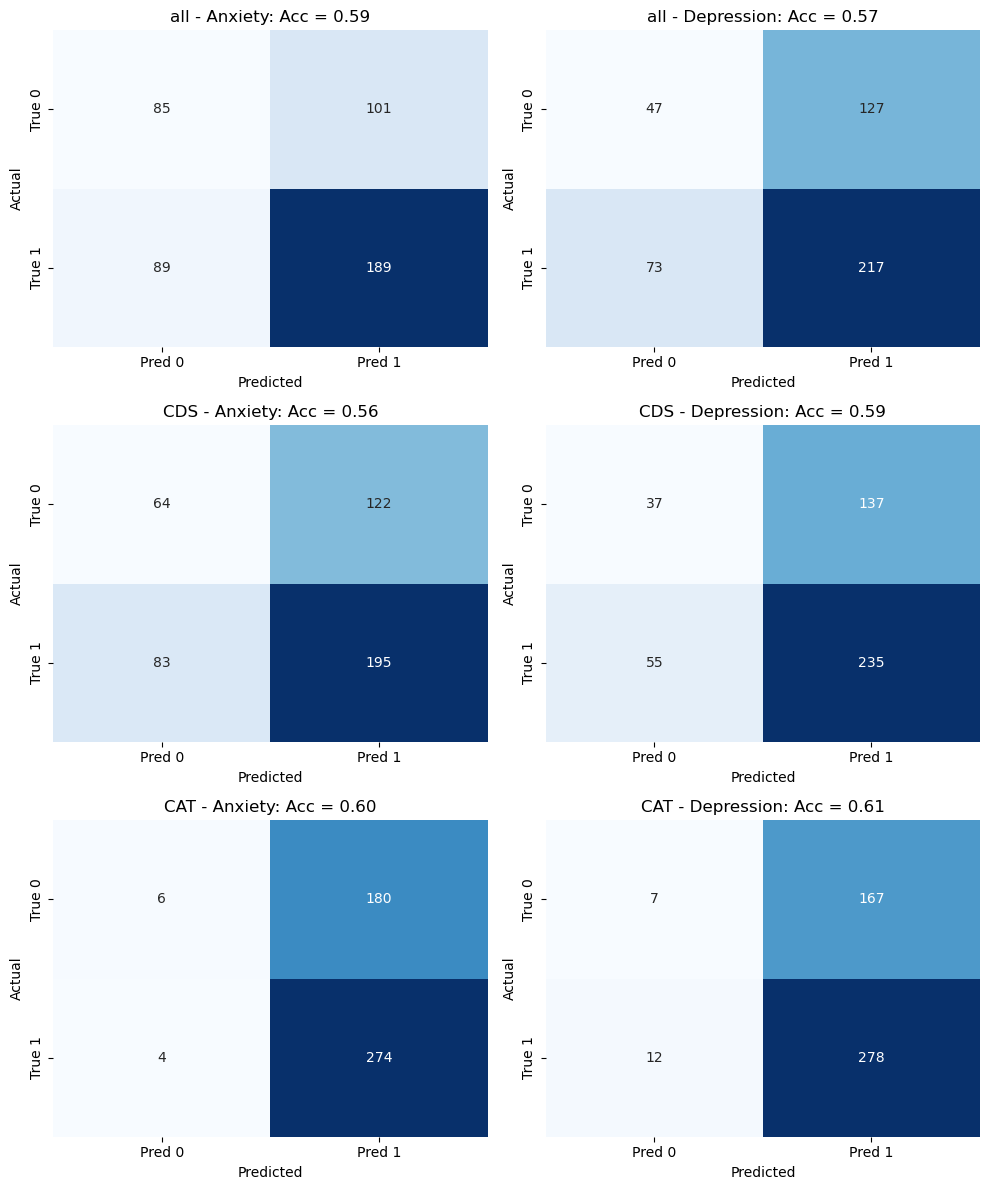

In [7]:
plot_confusion_matrices(all_results, label_names=['Anxiety', 'Depression'])

/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/s

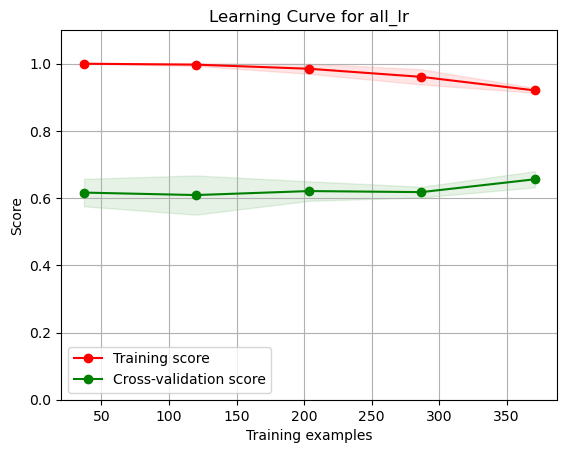

/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/markv98/anaconda3/lib/python3.11/site-packages/s

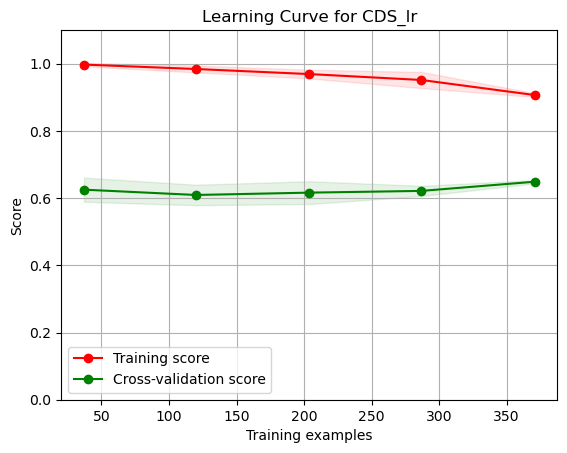

/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 450, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/Users/markv98/anaconda3/lib/python3.11/site-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel

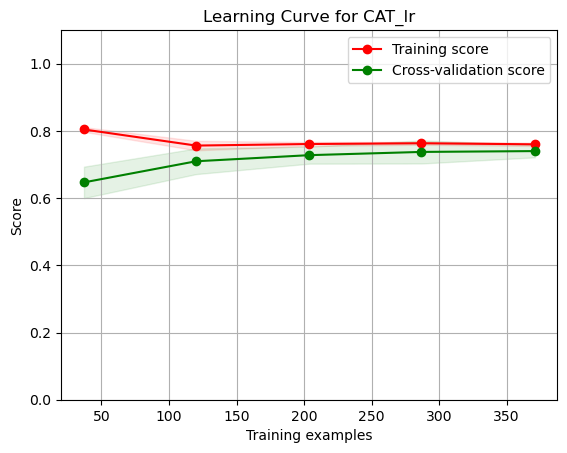

In [8]:
for subset, result in all_results.items():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        result.plot_training_curve()

In [9]:
for subset, result in all_results.items():
    print(f"Subset: {subset}")
    print(f"Best Hyperparameters: {result.clf.best_params_}")
    print("\n")

Subset: all
Best Hyperparameters: {'estimator__penalty': 'l1', 'estimator__solver': 'saga'}


Subset: CDS
Best Hyperparameters: {'estimator__penalty': 'l1', 'estimator__solver': 'saga'}


Subset: CAT
Best Hyperparameters: {'estimator__penalty': 'l1', 'estimator__solver': 'saga'}




In [10]:
# Function to plot ROC curves per label per subset
def plot_roc_curves(all_results, label_names=['Anxiety', 'Depression']):
    plt.figure(figsize=(12, 6))

    # Separate plots for Anxiety and Depression
    for i, label in enumerate(label_names):
        plt.subplot(1, 2, i+1)
        plt.title(f'ROC Curve - {label}')
        
        for subset, result in all_results.items():
            # Predict probabilities again (y_pred_proba)
            y_proba = result.clf.predict(result.X_test)  # result.X_test needs to be saved in NNResults
            
            if isinstance(y_proba, list):
                y_proba = y_proba[0]  # For Keras predict returning list

            fpr, tpr, _ = roc_curve(result.y_test.iloc[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{subset} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

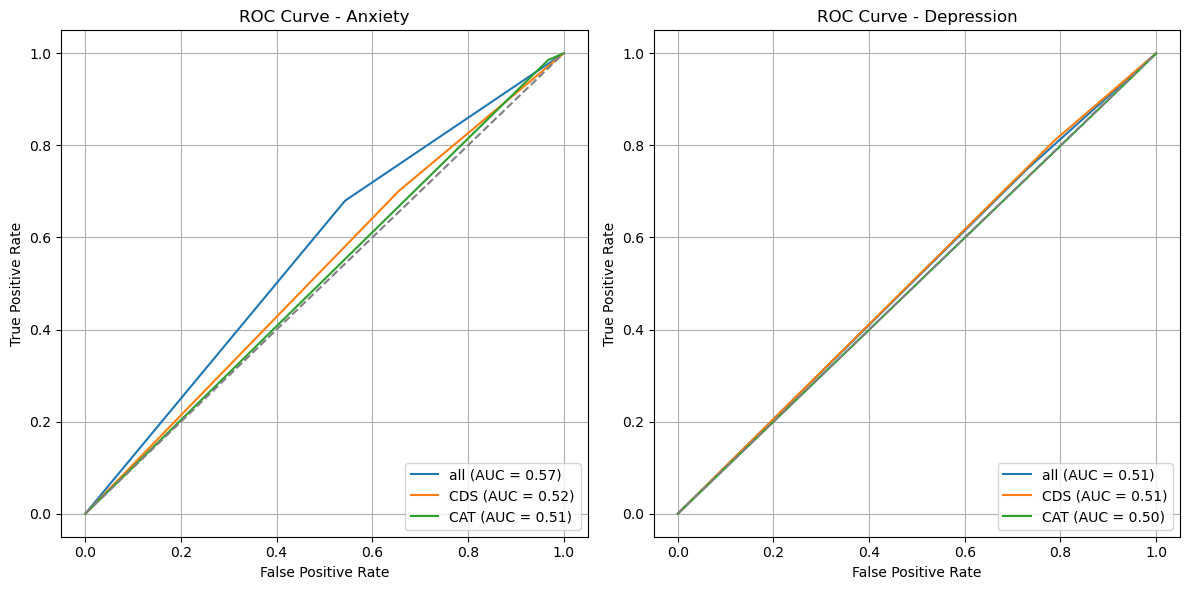

In [11]:
plot_roc_curves(all_results, label_names=['Anxiety', 'Depression'])

In [45]:
# print the JS visualization code to the notebook
import warnings
from sklearn.exceptions import ConvergenceWarning
subset = 'CAT'
result = all_results[subset]
# Create the list of all labels for the drop down list
list_of_labels = result.y_test.columns.to_list()
shap_dict = {}

background = shap.kmeans(result.X_test, 100)  # Cluster into 100 centroid
explainer = shap.KernelExplainer(result.clf.predict, result.X_test)

for label in list_of_labels:
    # Suppress only ConvergenceWarnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        shap_dict[label] = explainer(result.X_test)
    print(f"Current Label Shown: {label}\n")

Using 464 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/464 [00:00<?, ?it/s]

Current Label Shown: group_anxiety



  0%|          | 0/464 [00:00<?, ?it/s]

Current Label Shown: group_depression



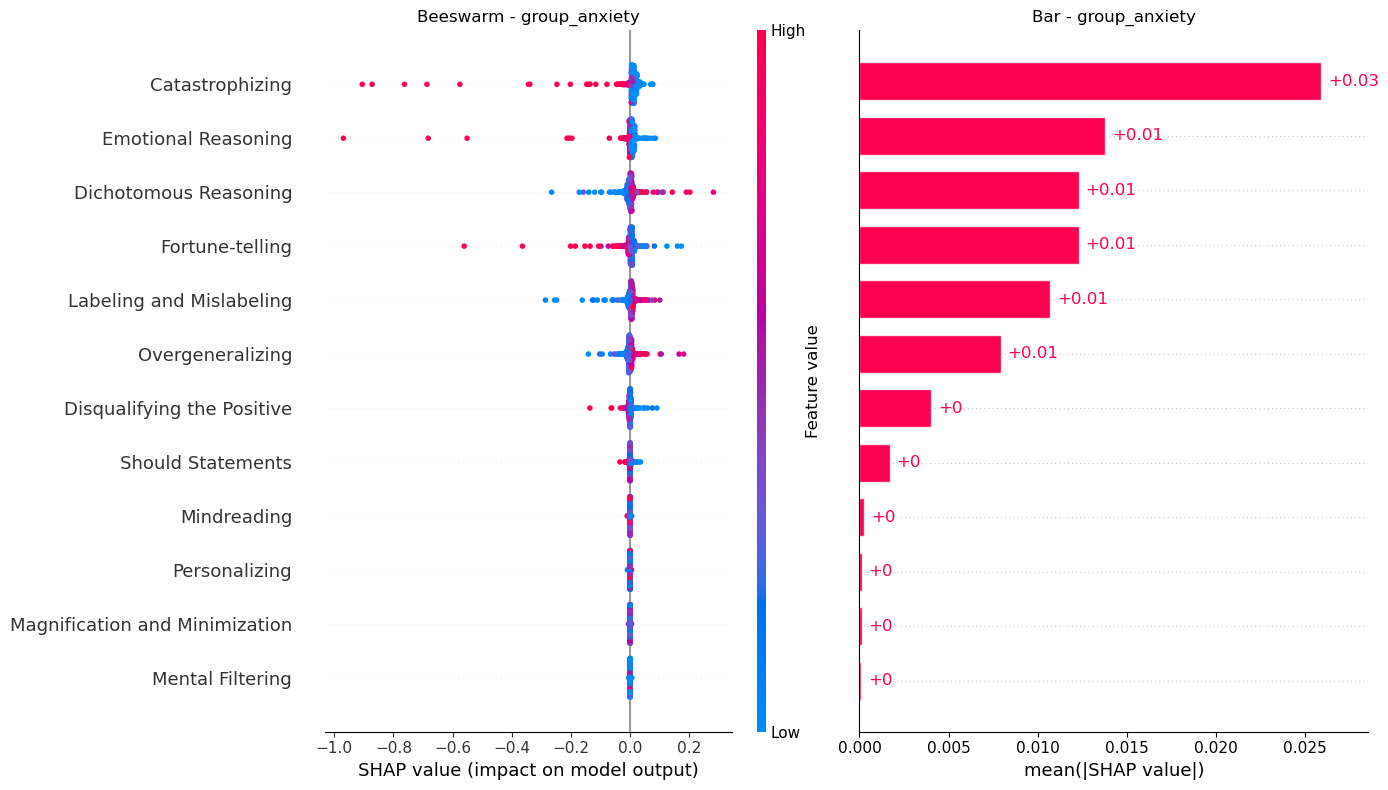

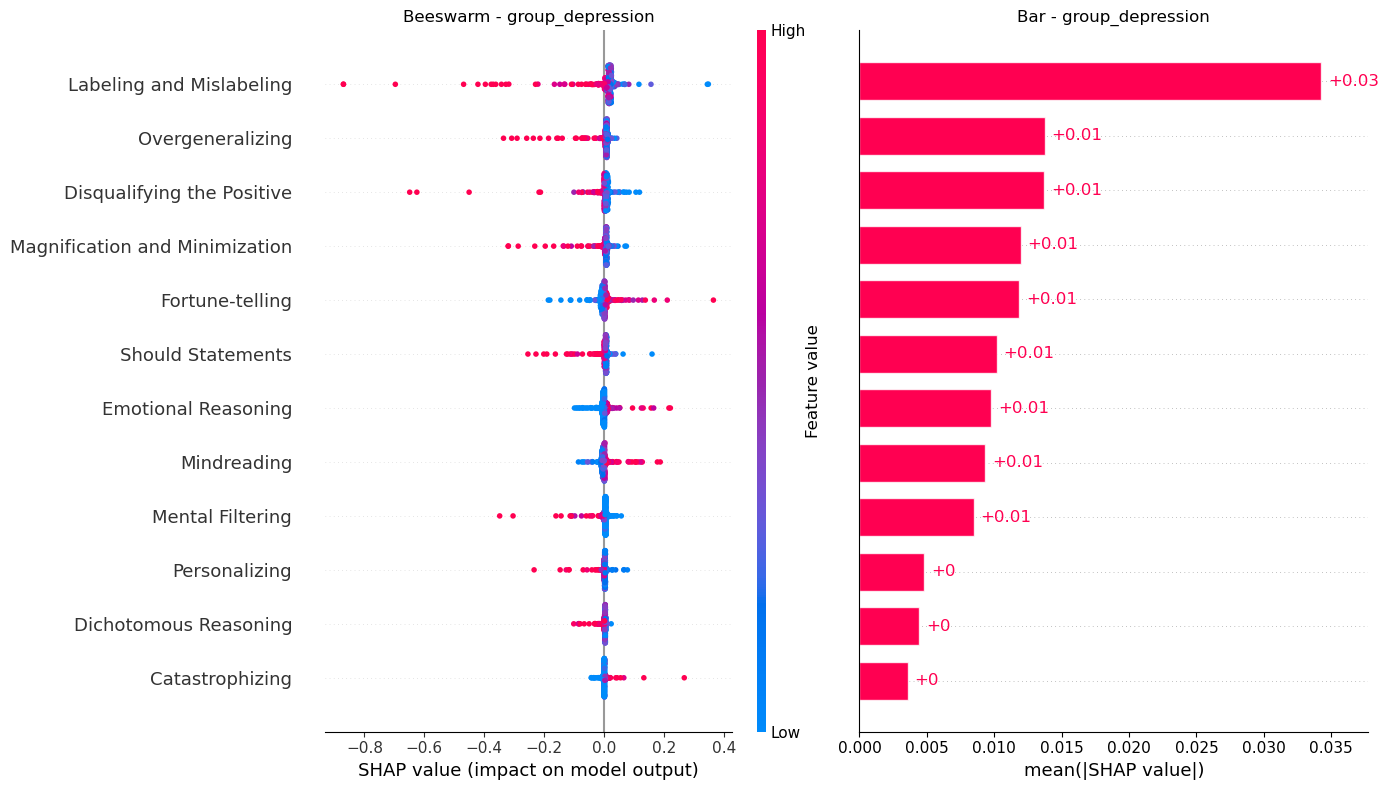

In [47]:
for i, (key, value) in enumerate(shap_dict.items()):
    value.feature_names = result.col_names
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Wider plot

    # Beeswarm on first axis
    shap.plots.beeswarm(
        value[:, :, i],
        show=False,
        ax=axs[0],
        max_display=20,
        plot_size = None
    )
    axs[0].set_title(f"Beeswarm - {key}")

    # Bar on second axis
    shap.plots.bar(
        value[:, :, i],
        show=False,
        ax=axs[1],
        max_display=20
    )
    axs[1].yaxis.set_visible(False)
    # axs[1].figure.set_size_inches(20, 8)
    axs[1].set_title(f"Bar - {key}")

    plt.tight_layout()
    plt.show()